# RISM - A Gentle Introduction

We are going to write a Python implementation of the extended RISM equation with the goal of computing the direct, indirect and total correlation function along with the radial distribution function.

First, we import the libraries we will be needing:

In [188]:
import numpy as np
from scipy.fftpack import dstn, idstn
from scipy.special import erf
import matplotlib.pyplot as plt

First, we need to set up our problem domain. While the RISM equations are written as continuous functions $r$ (e.g. $c(r)$), computationally we solve them on a discretised grid.

We'll set up a discrete domain of length (or radius since we are working with spherically symmetric functions) $r = 15\, Å$ partitioned into $N = 100$ points. The resulting grid spacing is given by $\Delta r = \frac{r}{N}$.

In [189]:
r = 20.48
N = 1024
dr = r / N

We also want to set up a grid spacing for our Fourier-space grid such that $\Delta r \Delta k = \frac{\pi}{N}$

In [190]:
dk = 2.0 * np.pi / (2.0 * N * dr)

Lets check the equality we stated above:

In [191]:
np.isclose(dr * dk, np.pi / N)

True

We use `np.isclose()` here because we are comparing floating point numbers. Using `==` would not work since there is always some precision loss with floats. You need to compared them within tolerances instead.

We can use these to generate our real and Fourier-space midpoint grids.

In [192]:
r_grid = np.arange(0.5, N, 1.0) * dr
k_grid = np.arange(0.5, N, 1.0) * dk

## Simple Lennard-Jones Liquid

Now that we have our problem domain set up, we can focus on solving a particular problem. We're going to look at solving RISM for a simple Lennard-Jones liquid.

We first need to set up the thermodynamical state of the system and the unit systems we're going to use. We'll be working with energies in kJ / mol.

In [193]:
T = 300.0 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1.0 / T / kB # Thermodynamic Beta
ns = 1 # Number of ites

We also need to define the parameters for Argon, as well as its number density. 

In [194]:
ar_epsilon = 0.997 # kJ / mol
ar_sigma = 3.4 # Angstroms
ar_dens = 0.02071 # 1 / Angstroms^3
ar_rho = np.diag([ar_dens])

We need to tabulate the LJ potential with the above parameters. We define a function to evaluate the potential over a grid, and then we plot the potential.

In [195]:
def LJ(epsilon, sigma, r):
    return 4.0 * epsilon * ( np.power( (sigma / r), 12) - np.power( (sigma / r), 6) )

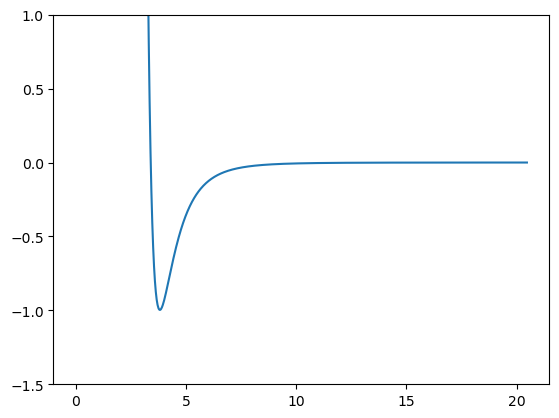

In [196]:
ar_ur = np.zeros((N, ns, ns))
ar_ur[:, 0, 0] = LJ(ar_epsilon, ar_sigma, r_grid)

plt.plot(r_grid, ar_ur[:, 0, 0])
plt.ylim([-1.5, 1.0])
plt.show()

One aspect of the RISM equation that we need to consider is the intramolecular correlation function $\omega(k)$. In the case of a simple liquid, $\omega(k) = 1$, in which case we the RISM equation reduces to the Ornstein-Zernike (OZ) equation.
We'll implement the full RISM equation, but we will set $\omega(k)$ to 1 for the case our current system.

In [197]:
ar_wk = np.ones((N, ns, ns))

Another aspect is the closure. The closure is what relates our unknowns ($h(r)$ and $c(r)$), in a sense "closing" the RISM equation.
Generally the closure in terms of $c(r)$ is $$ c(r) = e^{-\beta u(r) + t(r) - B(r)} - t(r) - 1 $$ where $B(r)$ is the bridge function - something that we need to approximate - and $t(r) = h(r) - c(r)$ is the indirect correlation function.

We're going to use the simplest approximation, $B(r) = 0$. This is the Hypernetted Chain (HNC) closure.

$$ c(r) = e^{-\beta u(r) + t(r)} - t(r) - 1 $$

In [198]:
def HNC(beta, ur, tr):
    return np.exp(-beta * ur + tr) - 1.0 - tr

The final detail before we implement the RISM equation is that we need to be able to transform our correlation functions into Fourier-space and back.
We use the Fourier transforms of spherically symmetric functions:

$$ f(k) = 4 \pi \int_0^\infty f(r) r^2 \frac{\sin(kr)}{kr} dr $$

and the inverse:

$$ f(r) = \frac{1}{2 \pi^2} \int_0^\infty f(k) k^2 \frac{\sin(kr)}{kr} dk $$

The function $J_0(kr) = \frac{\sin(kr)}{kr}$ is the zeroth-order spherical Bessel function of the first kind, so sometimes these transforms are called Fourier-Bessel (or Hankel) transforms.

This can neatly be related to the Fourier sine transform:

$$ f(k) = \int_0^\infty f(r) \sin(kr) dr $$

$$ f(r) = \frac{2}{\pi} \int_0^\infty f(k) \sin(kr) dk $$

So that the fourier transform of the spherically symmetric function $f(r)$ is just the Fourier sine transform of the function $f(r) \cdot r$

Scipy has discrete sine transform functions we can use.

In [199]:
def fbt(fr, r, k, dr):
    return 2.0 * np.pi * dr * dstn(fr * r[:, np.newaxis, np.newaxis], type=4, axes=[0]) / k[:, np.newaxis, np.newaxis]

def ifbt(fk, r, k, dk):
    return dk / 4.0 / np.pi / np.pi * idstn(fk * k[:, np.newaxis, np.newaxis], type=4, axes=[0]) / r[:, np.newaxis, np.newaxis]

We have all the key parts to solve the RISM equation now.
The equation in Fourier-space is $$h(k) = \omega(k) * c(k) * \omega(k) - \rho * \omega(k) * c(k) * h(k)$$
We can rearrange this for $h(k)$ $$h(k) = [1 - \rho * \omega(k) * c(k)]^{-1} \omega(k) * c(k) * \omega(k)$$

For brevity, I'm going to drop the function argument $(k)$
$$h = [1 - \rho\omega c]^{-1} \omega c \omega$$

We're interested in calculating the indirect correlation function $t(k)$ $$t = [1 - \rho\omega c]^{-1} \omega c \omega - c$$

In [200]:
def RISM(cr, w, p, r, k, dr, dk):
    N = r.shape[0]
    I = np.eye(w.shape[1])
    tk = np.zeros_like(cr)
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)
    # Solve the RISM equation for t(k)
    for l in np.arange(0, N):
        tk[l] = w[l] @ ck[l] @ w[l] @ np.linalg.inv(I - p * w[l] * ck[l]) - ck[l]
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

We have all the equations we need to perform a single closure and RISM calculation. Now we need to numerically solve this problem.

The RISM equation is an integro-differential equation, and is posed to be solved using fixed-point iteration (i.e. the self-consistent approach used in electronic structure theory e.g. for solving Hartree-Fock).

We set some initial guess for $t_0(r)$, and use that as input into the closure and RISM equation, and get a new value out. If we represent the closure and RISM equation as an operator $F(\cdot)$ on $t(r)$ then we get a value of $F(t(r))$.

We can then mix this new value with our initial value to obtain a new solution for $t(r)$ $$t_1(r) = \alpha F(t_0(r))  + (1 - \alpha) t_0(r) $$

More generally $$t_{k+1}(r) = \alpha F(t_k(r)) + (1 + \alpha) t_k(r)$$

where $\alpha$ is a dampening parameter. The lower this is, the stiffer our iteration process is (because we're including more of the previous solution than the current). This is called Picard iteration.


We keep iterating this set of equations and check the difference between current and previous solutions until that difference is below some tolerance $\zeta$ $$ |t_{k+1}(r) - t_{k}(r)| < \zeta $$

Once the difference is below this tolerance, the calculation is finished.

We use an initial guess of $t(r) = 0$ and a tolerance of $\zeta = 1\times10^{-5}$

In [201]:
def picard_iteration(tolerance, max_steps, alpha, beta, wk, ur, rho, init_tr, r_grid, k_grid, dr, dk):

    tr = init_tr

    step = 0

    while step < max_steps:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = HNC(beta, ar_ur, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, ar_wk, ar_rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev
        
        # Checking the L2-norm between steps
        diff = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)
        
        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step and difference every 10 steps
        if step % 10 == 0:
            print("Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))

        # Test if the difference is below our tolerance
        if diff < tolerance:
            # Print the final step
            print("Final Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1

    return tr

def Ng_step(f, g):
    # f and g are our lists of f and g functions
    # We'll index relative to n = 2, so that we can better match the maths (2 rather than 3 because Python is a zero-indexed language)
    n = 2
    
    # First, preserve the shape of the inputs, since we'll be flattening them into vectors
    dims = f[0].shape
    
    # Compute the residuals. We need to flatten these into vectors.
    d_n = (g[n] - f[n]).flatten()
    d_1 = (g[n-1] - f[n-1]).flatten()
    d_2 = (g[n-2] - f[n-2]).flatten()
    
    d01 = d_n - d_1
    d02 = d_n - d_2
    
    # We can fill up A and b now
    A = np.zeros((2, 2))
    b = np.zeros(2)
    
    A[0, 0] = np.dot(d01, d01)
    A[0, 1] = np.dot(d01, d02)
    A[1, 0] = np.dot(d01, d02)
    A[1, 1] = np.dot(d02, d02)
    
    b[0] = np.dot(d_n, d01)
    b[1] = np.dot(d_n, d02)
    
    # We can now perform a linear solve to get x1 and x2
    x = np.linalg.solve(A, b)

    # And we can construct a new solution
    f_new = (1.0 - x[0] - x[1]) * g[n] 
    + x[0] * g[n-1] 
    + x[1] * g[n-2]
    
    return f_new.reshape(dims)


def Ng_iteration(tolerance, max_step, alpha, beta, ur, wk, rho, init_tr, r_grid, k_grid, dr, dk):
    # Set up our loop variable tr
    tr = init_tr
    
    # Define our counter
    step = 0
    
    # Define empty f and g lists
    f = []
    g = []
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = HNC(beta, ur, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, wk, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        # if we've not got a history of 3 solutions yet
        if len(f) < 3:
            
            tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

            # Update f and g lists.
            f.append(tr)
            g.append(tr_new)
            
        # Otherwise lets use the Ng method
        else:
        
            tr_new = Ng_step(f, g)

            # Update f and g lists
            f.append(tr)
            g.append(tr_new)
            
            
            # We want to keep the list to 3 elements, so we pop off the oldest elements
            f.pop(0)
            g.pop(0)
            
        # Check the convergence criterion
        diff = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 10 steps and difference
        if step % 1 == 0:
            print("Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))

        # Test if the difference is below our tolerance
        if diff < tolerance:
            print("Final Iteration: {step} Diff: {diff:.2e}".format(step=step, diff=diff))
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            print("Reached max steps!")
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr

def cost(tr, beta, wk, rho, ur, r_grid, k_grid, dr, dk):
        # t(r) -> c(r) from closure
        cr = HNC(beta, ur, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, wk, rho, r_grid, k_grid, dr, dk)

        return f_tr - tr

# Setting up parameters for iterations
tolerance = 1e-10
max_steps = 5000
step = 0

# 1.0 is essentially undamped direct iteration
alpha = 1.0

#tr_pic = picard_iteration(tolerance, max_steps, alpha, beta, ar_ur, ar_wk, ar_rho, np.zeros((N, ns, ns)), r_grid, k_grid, dr, dk)
#cr_pic = HNC(beta, ar_ur, tr_pic)
tr_ng = Ng_iteration(tolerance, max_steps, alpha, beta, ar_ur, ar_wk, ar_rho, np.zeros((N, ns, ns)), r_grid, k_grid, dr, dk)
cr_ng = HNC(beta, ar_ur, tr_ng)

from scipy.optimize import root

result = root(cost, np.zeros((N, ns, ns)), method="anderson", args=(beta, ar_wk, ar_rho, ar_ur, r_grid, k_grid, dr, dk))
print(result)
tr = result.x
cr = HNC(beta, ar_ur, tr)

Iteration: 0 Diff: 2.43e+00
Iteration: 1 Diff: 7.87e-01
Iteration: 2 Diff: 9.57e-01
Iteration: 3 Diff: 5.20e+00
Iteration: 4 Diff: 1.13e+01
Iteration: 5 Diff: 1.42e+00
Iteration: 6 Diff: 2.78e-01
Iteration: 7 Diff: 1.63e-01
Iteration: 8 Diff: 4.27e+00
Iteration: 9 Diff: 2.99e+00
Iteration: 10 Diff: 1.33e+00
Iteration: 11 Diff: 6.77e-01
Iteration: 12 Diff: 2.62e+00
Iteration: 13 Diff: 5.46e+00
Iteration: 14 Diff: 4.16e-01
Iteration: 15 Diff: 6.31e-03
Iteration: 16 Diff: 4.06e-04
Iteration: 17 Diff: 7.98e-02
Iteration: 18 Diff: 3.33e-01
Iteration: 19 Diff: 8.23e-03
Iteration: 20 Diff: 6.80e-04
Iteration: 21 Diff: 6.22e-05
Iteration: 22 Diff: 5.25e-04


Iteration: 23 Diff: 1.56e-03
Iteration: 24 Diff: 2.57e-03
Iteration: 25 Diff: 4.19e-03
Iteration: 26 Diff: 6.87e-04
Iteration: 27 Diff: 1.41e-04
Iteration: 28 Diff: 4.39e-05
Iteration: 29 Diff: 1.07e-04
Iteration: 30 Diff: 1.14e-03
Iteration: 31 Diff: 2.91e-04
Iteration: 32 Diff: 8.26e-05
Iteration: 33 Diff: 2.32e-05
Iteration: 34 Diff: 1.02e-05
Iteration: 35 Diff: 1.35e-04
Iteration: 36 Diff: 2.85e-04
Iteration: 37 Diff: 3.74e-05
Iteration: 38 Diff: 5.31e-06
Iteration: 39 Diff: 8.38e-08
Iteration: 40 Diff: 4.01e-09
Iteration: 41 Diff: 4.38e-08
Iteration: 42 Diff: 1.38e-06
Iteration: 43 Diff: 2.69e-06
Iteration: 44 Diff: 2.33e-07
Iteration: 45 Diff: 5.58e-08
Iteration: 46 Diff: 7.33e-09
Iteration: 47 Diff: 1.19e-08
Iteration: 48 Diff: 2.40e-07
Iteration: 49 Diff: 2.44e-07
Iteration: 50 Diff: 9.28e-09
Iteration: 51 Diff: 5.29e-10
Iteration: 52 Diff: 8.98e-11
Final Iteration: 52 Diff: 8.98e-11
 message: A solution was found at the specified tolerance.
 success: True
  status: 1
     fun:

Once solved, we can use the calculated correlation functions to calculate the radial distribution function and plot it.

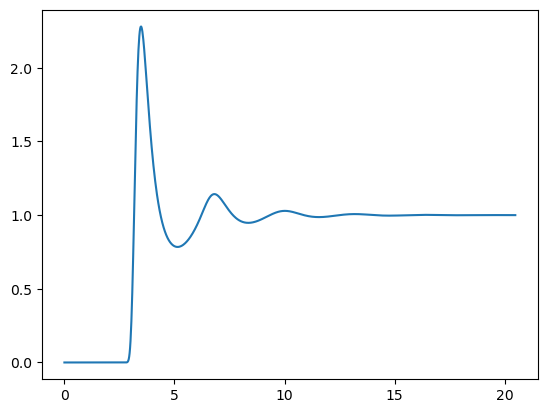

In [202]:
# Get h(r)
hr = tr + cr
#hr_pic = tr_pic + cr_pic
#hr_ng = tr_ng + cr_ng

# Get and plot g(r)
gr = hr + 1
#gr_pic = hr_pic + 1
#gr_ng = hr_ng + 1

plt.plot(r_grid, gr[:, 0, 0])
#plt.plot(r_grid, gr_pic[:, 0, 0])
#plt.plot(r_grid, gr_ng[:, 0, 0])
plt.show()

This is the radial distribution function for a Lennard-Jones Argon liquid!

On your machine you might find that it took over 300 iterations to come to a solution.
We're using a very simple iteration scheme, but there are more complex iteration schemes we can use that can reduce the number of iterations.
We will look at one convergence acceleration method later, but most methods are beyond the scope of this tutorial.